# Natural Language Processing with Disaster Tweets

The task was to classify whether tweets concern a natural disaster or not. The dataset comes from https://www.kaggle.com/competitions/nlp-getting-started

# Dataset overview

First things first - let's take a look at the dataset to find out what we have to deal with.

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The dataset consists of 4 columns, one of which being redundant (id), and the target. One can easily see that `keyword` and `location` are likely to be null.

In [ ]:
print(f'''
Rows in total: {len(train_df)}
Rows with no keyword: {len(train_df[train_df['keyword'].isna()])}
Rows with no location: {len(train_df[train_df['location'].isna()])}
Rows with no text: {len(train_df[train_df['text'].isna()])}
''')


Rows in total: 7613
Rows with no keyword: 61
Rows with no location: 2533
Rows with no text: 0



Fortunately keyword is missing in only 61 rows and the location is present in most of the samples.

# Initial approach - Random Forest

We decided to start off with something simple and try to find an efficient solution that would not involve neural networks. 

## Preprocessing

As classifiers only operate on numeric values, the first challenge was to convert our text input into valid input. Having no prior experience with NLP, we focused mostly on creating metadata related columns.

In [ ]:
import pandas as pd
from statistics import mean
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from string import punctuation

def count_capital_letters_part(text):
    capital_letters = 0
    c: str
    for c in text:
        if c.isupper():
            capital_letters += 1

    return capital_letters / len(text) if len(text) > 0 else 0
    
def avg_word_length(text):
    return mean([len(word) for word in text.split()])

def calc_compound_sentiment(text):
    if len(text) == 0:
        return 0
    
    return SentimentIntensityAnalyzer().polarity_scores(text)['compound']


def calc_location_credibility(loc):
    words = loc.split()

    if len(words) == 0:
        return 0

    score = 0
    for word in words:
        if word[0].isupper():
            score += 1
        else:
            score -= 1
    
    return score / len(words)

def calculate_top_keywords(df, y):
    top_target_keywords = df[y==1].keyword.value_counts().head(100)
    top_non_target_keywords = df[y==0].keyword.value_counts().head(100)

    words_1 = set(list(top_target_keywords.index))
    words_0 = set(list(top_non_target_keywords.index))
    intersection = list(words_1.intersection(words_0)) # identification of ambigual keywords

    top_target_keywords = top_target_keywords.drop(intersection)
    top_non_target_keywords = top_non_target_keywords.drop(intersection)
    
    return top_target_keywords, top_non_target_keywords


def generate_columns(df):
    _df = df.copy()
    generated_df = pd.DataFrame()
    _df[['keyword', 'location']] = _df[['keyword', 'location']].fillna(value='')
    _df['keyword'] = _df['keyword'].str.replace('%20', ' ') # %20 is actually a space but we don't want it
    
    top_target_keywords, top_non_target_keywords = calculate_top_keywords(df, y)
    
    generated_df['text_length'] = _df['text'].str.len()
    generated_df['capital_letters_part'] = _df['text'].apply(count_capital_letters_part)
    generated_df['avg_word_length'] = _df['text'].apply(avg_word_length)
    generated_df['sentiment'] = _df['text'].apply(calc_compound_sentiment)
    generated_df['hashtag_count'] = _df['text'].apply(lambda text: text.count('#'))
    generated_df['mention_count'] = _df['text'].apply(lambda text: text.count('@'))
    generated_df['url_count'] = _df['text'].apply(lambda text: text.count('http')+text.count('https'))
    generated_df['punctuation_marks_per_char'] = _df['text'].apply(lambda text: (text.count('?') + text.count('!') + text.count('.')) / len(text))
    generated_df['keyword_sentiment'] = _df['keyword'].apply(calc_compound_sentiment)
    generated_df['location_credibility'] = _df['location'].apply(calc_location_credibility)
    generated_df['target_keyword'] = _df['keyword'].apply(lambda keyword: keyword in top_target_keywords)
    generated_df['non_target_keyword'] = _df['keyword'].apply(lambda keyword: keyword in top_non_target_keywords)
    
    generated_df['cleaned_text'] = df['text'].apply(word_tokenize)
    generated_df['cleaned_text'] = generated_df['cleaned_text'].apply(
        lambda row: [word for word in row if word not in punctuation]
    )
    
    generated_df['word_amount'] = generated_df['cleaned_text'].apply(lambda row: len(row))
    generated_df['unique_word_amount'] = generated_df['cleaned_text'].apply(lambda row: len(list(set(row))))
    generated_df = generated_df.drop('cleaned_text', axis=1)

    return generated_df


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The most important of the functions above is the last one, which does the actual job of creating a new dataframe with numeric values based on the source dataframe.
Most of the columns are self-explanatory, except for a few of them:
- keyword_sentiment - overall ("compound") sentiment of text calculated using `SentimentIntensityAnalyzer` from `nltk` package
- location_credibility - this is a factor based on an observation, that strings in which each word starts with a capital letter are more likely to be a real location
- target_keyword - tells whether the keyword if the sample is among the top 100 keywords for samples with target equal to 1
- non_target_keyword - same as the previous one but for samples with target equal to 0

## Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize(X):
  scaler = StandardScaler()
  return scaler.fit_transform(X)

## Preprocess function

In [ ]:
def preprocess(X):
    _X = X.copy()
    _X = _X.iloc[:, 1:] # we don't want to include id as it should affect predictions
    _X = generate_columns(_X)
    _X = standardize(_X)
    return _X

## Building the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('train.csv')
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.3)

In [ ]:
X_train_preprocessed = preprocess(X_train)

C:\Users\Aleks\AppData\Local\Temp\ipykernel_24096\4116542477.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_target_keywords = df[y==1].keyword.value_counts().head(100)
C:\Users\Aleks\AppData\Local\Temp\ipykernel_24096\4116542477.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_non_target_keywords = df[y==0].keyword.value_counts().head(100)


In [ ]:
# we create initial model
model = RandomForestClassifier()
model.fit(X_train_preprocessed, y_train)

RandomForestClassifier()

# Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 6, 9, 12, 15],
}

grid_search = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X_train_preprocessed, y_train)

best_rf = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': 12, 'n_estimators': 250}


GridSearch method indicated that the best results will be obtained when the maximum depth of the tree will be 12 and 150 estimators will be used.

## Prediction

In [ ]:
from sklearn.metrics import classification_report

X_test_preprocessed = preprocess(X_test)
y_pred = best_rf.predict(X_test_preprocessed)

print(classification_report(y_test, y_pred))

C:\Users\Aleks\AppData\Local\Temp\ipykernel_24096\4116542477.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_target_keywords = df[y==1].keyword.value_counts().head(100)
C:\Users\Aleks\AppData\Local\Temp\ipykernel_24096\4116542477.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_non_target_keywords = df[y==0].keyword.value_counts().head(100)


              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1303
           1       0.72      0.67      0.70       981

    accuracy                           0.75      2284
   macro avg       0.75      0.74      0.74      2284
weighted avg       0.75      0.75      0.75      2284



As we may see, the approach aimed at omitting the usage of neural networks did not really suceed, providing only 75% accuracy. That pushed us forward seeking another, more advanced solution.

# Visual analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Correlation matrix

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


<AxesSubplot:>

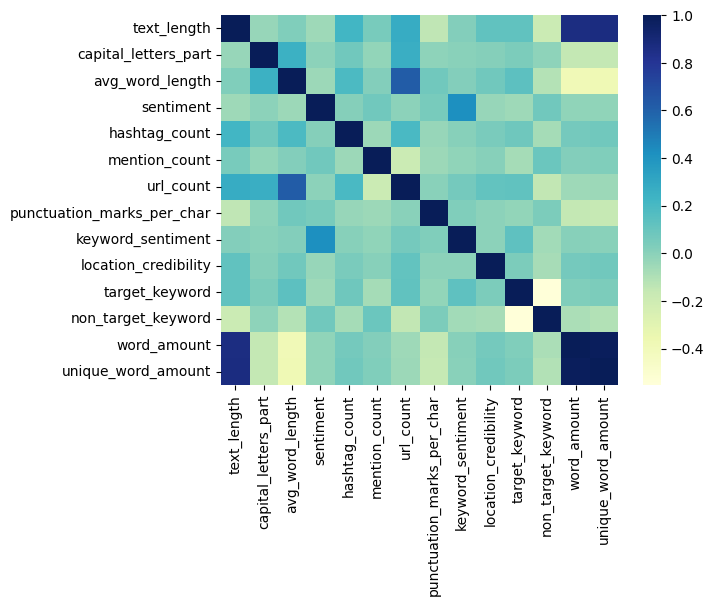

In [ ]:
data = generate_columns(X_train)
sns.heatmap(data.corr(), cmap="YlGnBu")

## Feature importance

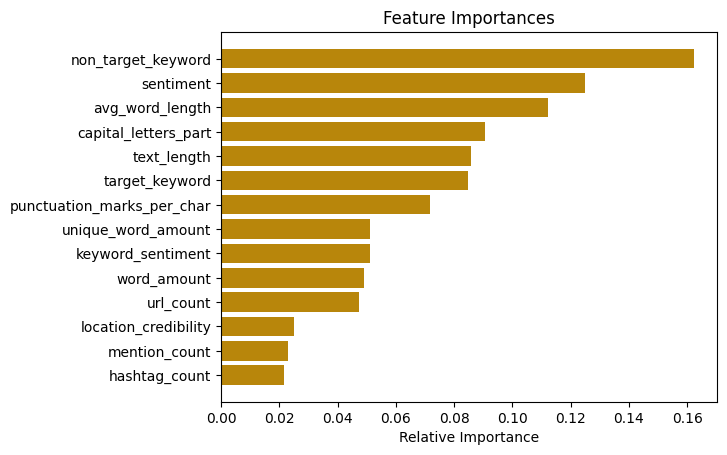

In [ ]:
feature_importances = pd.DataFrame(best_rf.feature_importances_,
                                   kolumny.columns,
                                   columns=['Importance'])

feature_importance_sorted = feature_importances.sort_values(by='Importance', ascending=True).head(20)

plt.title('Feature Importances')

plt.barh(feature_importance_sorted.index, feature_importance_sorted["Importance"],
         color='darkgoldenrod')
plt.xlabel('Relative Importance')
plt.show()

## Confusion matrix

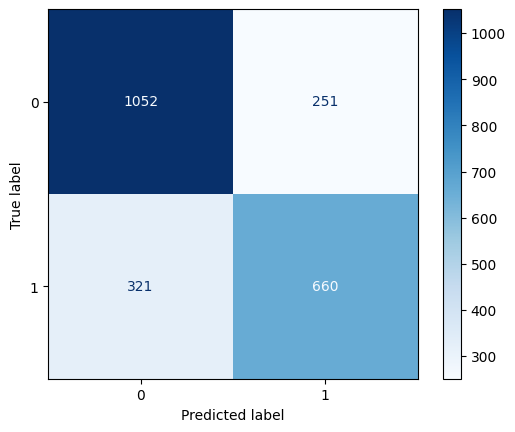

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

## Impact

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(data)

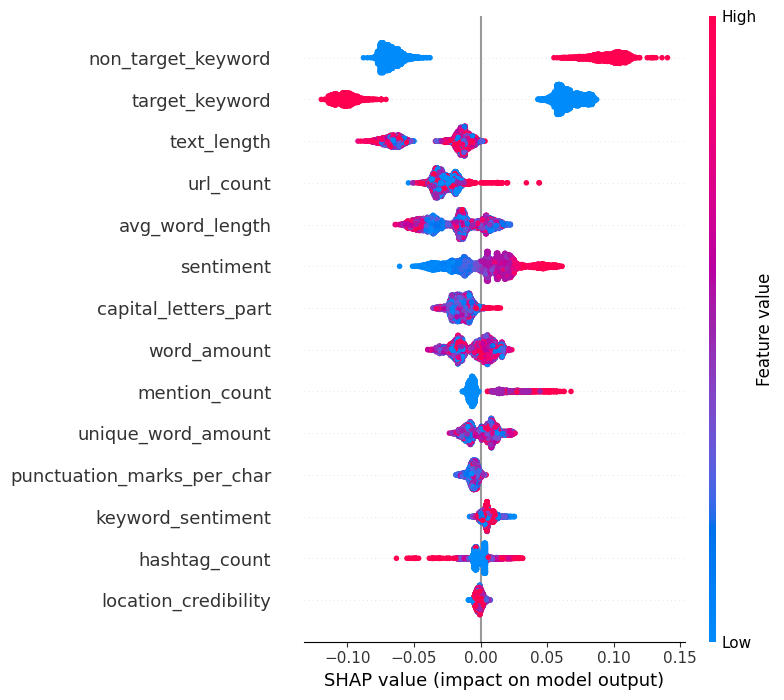

In [ ]:
shap.summary_plot(shap_values[0],
                  data.values,
                  feature_names = data.columns
                 )

# Second approach - TFIDF

Our decison was to reach for TFIDF, method based on the idea that the importance of a word in a tweet or corpus (the whole set we're working on) is proportional to its frequency in the tweet and inversely proportional to its frequency in the corpus. This means that a term that appears frequently in a tweet but rarely in the corpus is more important than a term that appears frequently in both the tweet and the corpus.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


def tfidf(column: pd.Series) -> tuple[TfidfVectorizer, pd.DataFrame]:
    vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]+\b', # exclude digits
                                 stop_words=list(ENGLISH_STOP_WORDS)) # exclude stop words
    sparse_matrix = vectorizer.fit_transform(column.str.lower())
    feature_names = vectorizer.get_feature_names_out()
    
    return vectorizer, pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=feature_names)

def generate_tfidf_columns(df) -> tuple[pd.DataFrame, TfidfVectorizer]:
    _df = df.copy()
    text_vectorizer, text_tfidf = tfidf(_df['text'])
    
    return text_tfidf, text_vectorizer

def apply_vectorizer_to_test(X_test: pd.DataFrame, text_vectorizer) -> pd.DataFrame:   
    vectorized_text = text_vectorizer.transform(X_test['text'])
    X_text = pd.DataFrame.sparse.from_spmatrix(vectorized_text, 
                                               columns=text_vectorizer.get_feature_names_out())
    
    return X_text

In [ ]:
X_train_tfidf, text_vectorizer = generate_tfidf_columns(X_train)

tfidf_classifier = RandomForestClassifier()

tfidf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [ ]:
X_test_tfidf = apply_vectorizer_to_test(X_test, text_vectorizer)
y_pred_tfidf = tfidf_classifier.predict(X_test_tfidf)

In [ ]:
print(classification_report(y_test, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1303
           1       0.86      0.59      0.70       981

    accuracy                           0.78      2284
   macro avg       0.80      0.76      0.77      2284
weighted avg       0.80      0.78      0.77      2284



Tfidf seems to be slightly more accurate than the previous approach, yet does not satisfy us.

# Third approach - BERT
We have come to the conclusion that achieving better results will probably only be possible if we use neural networks. Here we decided to use one of the most popular transformers for NLP - Bidirectional Encoder Representations from Transformers (BERT).

## Preprocessing


In [78]:
nltk.download('punkt')
import re
import tensorflow as tf
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
from transformers import create_optimizer
from transformers import TFAutoModelForSequenceClassification
from transformers.keras_callbacks import KerasMetricCallback
from transformers import pipeline
import pandas as pd
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [79]:
df = pd.read_csv('train.csv')

In [80]:
def removeURL(dataframe):
  _dataframe = dataframe.copy()
  _dataframe['text'] = _dataframe['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) 
  return _dataframe

When using BERT for NLP, little preprocessing is required as the model can acquire information from punctuation, and to some extent also from numbers. Therefore we decided to limit preprocessing to removing URLs from the tweets as they do not contain any information that could benefit our model.

In [81]:
df_clean = removeURL(df)

In [82]:
df_clean = df_clean.rename(columns = {"target":"label"})
y = df_clean['label']
X = df_clean['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
train_dataset = pd.concat([X_train, y_train], axis = 1)
test_dataset = pd.concat([X_test, y_test], axis = 1)
train_dataset = Dataset.from_pandas(train_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

In [83]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [84]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched = True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched = True)

Map:   0%|          | 0/5709 [00:00<?, ? examples/s]

Map:   0%|          | 0/1904 [00:00<?, ? examples/s]

## Buiilding the model

In [85]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
accuracy = evaluate.load("accuracy")

In [86]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "FALSE", 1: "TRUE"}
label2id = {"FALSE": 0, "TRUE": 1}

In [87]:
batch_size = 16
num_epochs = 3
batches_per_epoch = len(tokenized_train_dataset)
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [88]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_59', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [89]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_train_dataset,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_validation_set = model.prepare_tf_dataset(
    tokenized_test_dataset,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [90]:
model.compile(optimizer=optimizer, metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.



## Training
We are training the model for 3 epochs with minibatches of size 16, using validation set to monitor overfitting. 

In [94]:
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=10)

Epoch 1/10
356/356 [==============================] - 38s 106ms/step - loss: 0.0323 - accuracy: 0.9849 - val_loss: 0.9959 - val_accuracy: 0.8199
Epoch 2/10
356/356 [==============================] - 38s 105ms/step - loss: 0.0299 - accuracy: 0.9858 - val_loss: 1.0881 - val_accuracy: 0.8093
Epoch 3/10
356/356 [==============================] - 37s 103ms/step - loss: 0.0289 - accuracy: 0.9863 - val_loss: 1.0558 - val_accuracy: 0.8157
Epoch 4/10
356/356 [==============================] - 38s 105ms/step - loss: 0.0283 - accuracy: 0.9856 - val_loss: 1.0937 - val_accuracy: 0.8188
Epoch 5/10
356/356 [==============================] - 36s 102ms/step - loss: 0.0273 - accuracy: 0.9867 - val_loss: 1.1296 - val_accuracy: 0.8214
Epoch 6/10
356/356 [==============================] - 37s 104ms/step - loss: 0.0276 - accuracy: 0.9851 - val_loss: 1.2243 - val_accuracy: 0.7857
Epoch 7/10
356/356 [==============================] - 38s 106ms/step - loss: 0.0269 - accuracy: 0.9870 - val_loss: 1.1640 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


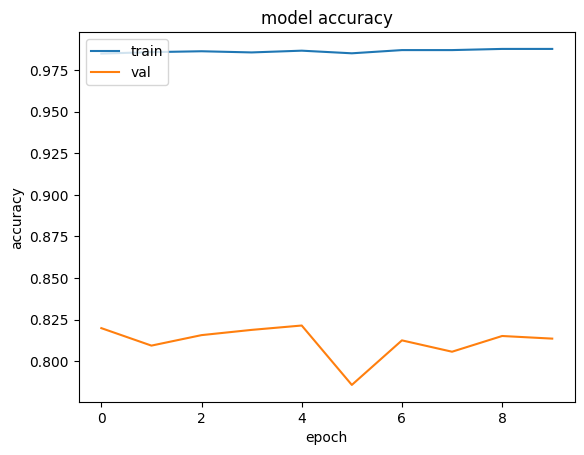

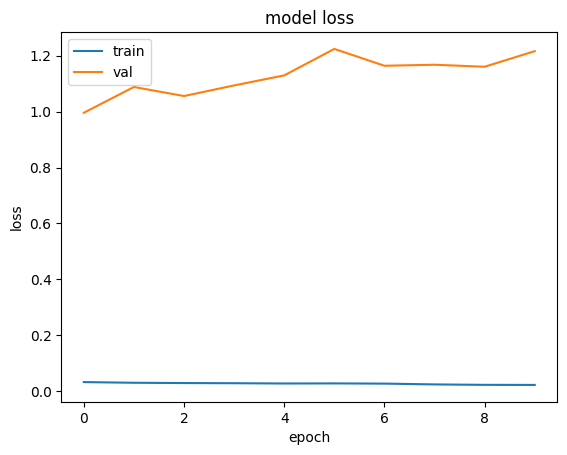

In [98]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [101]:
model2 = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)
model2.compile(optimizer=optimizer, metrics=['accuracy'])

history2 = model2.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=4)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_99', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/4
356/356 [==============================] - 88s 169ms/step - loss: 0.4365 - accuracy: 0.8069 - val_loss: 0.4340 - val_accuracy: 0.8188
Epoch 2/4
356/356 [==============================] - 38s 107ms/step - loss: 0.3222 - accuracy: 0.8724 - val_loss: 0.4395 - val_accuracy: 0.8267
Epoch 3/4
356/356 [==============================] - 38s 106ms/step - loss: 0.2279 - accuracy: 0.9191 - val_loss: 0.4725 - val_accuracy: 0.8204
Epoch 4/4
356/356 [==============================] - 38s 107ms/step - loss: 0.1565 - accuracy: 0.9442 - val_loss: 0.5206 - val_accuracy: 0.8262


As we can see, the both the loss function and accuracy for the validation set have slightly deteriorated after the second epoch; when we tested fitting for more than 5 epochs the overfitting was even more obvious.

In [104]:
test = pd.read_csv('test.csv')
test_clean = removeURL(test)
classifier = pipeline("sentiment-analysis", model=model2, tokenizer = tokenizer)
y_pred = classifier(test['text'].tolist())

In [108]:
classifier = pipeline("sentiment-analysis", model=model2, tokenizer = tokenizer)
y_pred = classifier(X_test.tolist())

In [121]:
y_pred

0       FALSE
1       FALSE
2       FALSE
3        TRUE
4       FALSE
        ...  
1899     TRUE
1900     TRUE
1901    FALSE
1902     TRUE
1903     TRUE
Name: label, Length: 1904, dtype: object

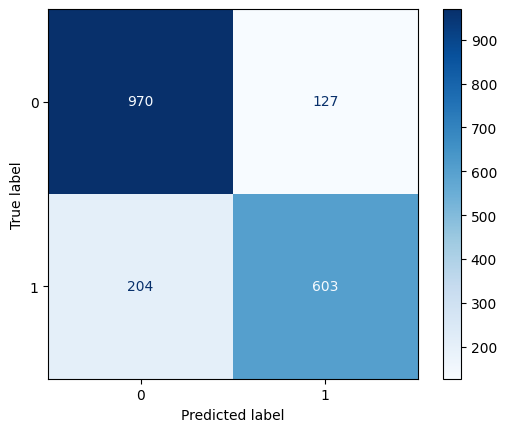

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = (y_pred == "TRUE").astype('int')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
y_pred = pd.DataFrame.from_records(y_pred)['label']
indices = list(test['id'])
y_pred = pd.DataFrame ({'id':indices,
                        'target':y_pred})
y_pred['target'] = (y_pred['target'] == "TRUE").astype('int')
y_pred.to_csv('rf_prediction.csv', index=False)

In [ ]:
from google.colab import files
files.download('rf_prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Summary

As expected, the best approach turned out to be the one involving neural networks, that is BERT.
It outperformed the other two methods for NLP classification, nevertheless the difference in accuracy
was not so substantial. <br><br>

| Method        | Accuracy |
|---------------|----------|
| Random Forest | 75%      |
| TFIDF         | 78       |
| BERT          | 82%      |